In [1]:
from transformers import AutoModel
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers import util, models, SentenceTransformer
from sentence_transformers.readers import InputExample
from sentence_transformers.util import cos_sim
from transformers import AutoTokenizer
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import gzip
import csv

In [2]:
sts_dataset_path = '../datasets/stsbenchmark.tsv.gz'

if not os.path.exists(sts_dataset_path):
    util.http_get('https://sbert.net/datasets/stsbenchmark.tsv.gz', sts_dataset_path)


In [3]:
train_samples = []
dev_samples = []
test_samples = []
with gzip.open(sts_dataset_path, 'rt', encoding='utf8') as f_in:
    df = pd.read_csv(f_in, delimiter='\t', quoting=csv.QUOTE_NONE)
    df_train = df[df["split"] == "train"]
    df_other = df[df["split"] != "train"]
    
display(df_train.head())
display(df_other.head())

,split,genre,dataset,year,sid,score,sentence1,sentence2
0,train,main-captions,MSRvid,2012test,1,5.00,A plane is taking off.,An air plane is taking off.
1,train,main-captions,MSRvid,2012test,4,3.80,A man is playing a large flute.,A man is playing a flute.
2,train,main-captions,MSRvid,2012test,5,3.80,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...
3,train,main-captions,MSRvid,2012test,6,2.60,Three men are playing chess.,Two men are playing chess.
4,train,main-captions,MSRvid,2012test,9,4.25,A man is playing the cello.,A man seated is playing the cello.


,split,genre,dataset,year,sid,score,sentence1,sentence2
5749,dev,main-captions,MSRvid,2012test,0,5.00,A man with a hard hat is dancing.,A man wearing a hard hat is dancing.
5750,dev,main-captions,MSRvid,2012test,2,4.75,A young child is riding a horse.,A child is riding a horse.
5751,dev,main-captions,MSRvid,2012test,3,5.00,A man is feeding a mouse to a snake.,The man is feeding a mouse to the snake.
5752,dev,main-captions,MSRvid,2012test,7,2.40,A woman is playing the guitar.,A man is playing guitar.
5753,dev,main-captions,MSRvid,2012test,8,2.75,A woman is playing the flute.,A man is playing a flute.


In [4]:
train_examples = []
other_examples = []

for i, x in df_train.iterrows():
    train_examples.append(InputExample(texts=[x['sentence1'], x['sentence2']], label=x["score"]/5.0))
    
for i, x in df_other.iterrows():
    other_examples.append(InputExample(texts=[x['sentence1'], x['sentence2']], label=x["score"]/5.0))
    
len(train_examples), len(other_examples)

(5749, 2879)

In [5]:
!mkdir ../output/bert-base-sent-tf
!mkdir ../output/electra-base-sent-tf

mkdir: cannot create directory ‘../output/bert-base-sent-tf’: File exists
mkdir: cannot create directory ‘../output/electra-base-sent-tf’: File exists


In [6]:
word_embedding_model = models.Transformer("bert-base-cased")
pooling_model = models.Pooling(
    word_embedding_model.get_word_embedding_dimension(),
    pooling_mode_mean_tokens=True,
    pooling_mode_cls_token=False,
    pooling_mode_max_tokens=False
)

bert_model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

evaluator = EmbeddingSimilarityEvaluator.from_input_examples(
    other_examples, name='sts_other', show_progress_bar=True
)
evaluator(bert_model, output_path="../output/bert-base-sent-tf")

scores = pd.read_csv("../output/bert-base-sent-tf/similarity_evaluation_sts_other_results.csv")
scores.head()

Batches:   0%|          | 0/180 [00:00<?, ?it/s]

Batches:   0%|          | 0/180 [00:00<?, ?it/s]

,epoch,steps,cosine_pearson,cosine_spearman,euclidean_pearson,euclidean_spearman,manhattan_pearson,manhattan_spearman,dot_pearson,dot_spearman
0,-1,-1,0.58156,0.586968,0.581859,0.584443,0.583219,0.585379,0.369181,0.363584
1,-1,-1,0.58156,0.586968,0.581859,0.584443,0.583219,0.585379,0.369181,0.363584
2,-1,-1,0.58156,0.586968,0.581859,0.584443,0.583219,0.585379,0.369181,0.363584
3,-1,-1,0.58156,0.586968,0.581859,0.584443,0.583219,0.585379,0.369181,0.363584
4,-1,-1,0.58156,0.586968,0.581859,0.584443,0.583219,0.585379,0.369181,0.363584


In [7]:
word_embedding_model = models.Transformer("google/electra-base-discriminator")
pooling_model = models.Pooling(
    word_embedding_model.get_word_embedding_dimension(),
    pooling_mode_mean_tokens=True,
    pooling_mode_cls_token=False,
    pooling_mode_max_tokens=False
)

electra_model = SentenceTransformer(modules=[word_embedding_model, pooling_model])


evaluator = EmbeddingSimilarityEvaluator.from_input_examples(
    other_examples, name='sts_other', show_progress_bar=True
)
evaluator(electra_model, output_path="../output/electra-base-sent-tf")

scores = pd.read_csv("../output/electra-base-sent-tf/similarity_evaluation_sts_other_results.csv")
scores.head()

Batches:   0%|          | 0/180 [00:00<?, ?it/s]

Batches:   0%|          | 0/180 [00:00<?, ?it/s]

,epoch,steps,cosine_pearson,cosine_spearman,euclidean_pearson,euclidean_spearman,manhattan_pearson,manhattan_spearman,dot_pearson,dot_spearman
0,-1,-1,0.221167,0.310772,0.295675,0.32243,0.29068,0.324751,0.117043,0.093014
1,-1,-1,0.221167,0.310772,0.295675,0.32243,0.29068,0.324751,0.117043,0.093014
2,-1,-1,0.221167,0.310772,0.295675,0.32243,0.29068,0.324751,0.117043,0.093014
3,-1,-1,0.221167,0.310772,0.295675,0.32243,0.29068,0.324751,0.117043,0.093014
4,-1,-1,0.221167,0.310772,0.295675,0.32243,0.29068,0.324751,0.117043,0.093014


## How many embeddings (%) will be calibrated?

In [8]:
bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
electra_tokenizer = AutoTokenizer.from_pretrained("google/electra-base-discriminator")

def get_ids_from_sentences(tokenizer):
    train_ids = set()
    for s in train_examples:
        s1, s2 = s.texts
        out1 = tokenizer(s1)["input_ids"]
        out2 = tokenizer(s2)["input_ids"]
        for x in out1:
            train_ids.add(x)
        for x in out2:
            train_ids.add(x)

    other_ids = set()
    for s in other_examples:
        s1, s2 = s.texts
        out1 = tokenizer(s1)["input_ids"]
        out2 = tokenizer(s2)["input_ids"]
        for x in out1:
            other_ids.add(x)
        for x in out2:
            other_ids.add(x)

    print(f"Length of train ids: {len(train_ids)}\nLength of other ids: {len(other_ids)}\n")
    return train_ids, other_ids

def get_overlap(train_ids, other_ids, tokenizer):
    print(f"Percentage of tuned embeddings in other: {len(train_ids & other_ids)/len(other_ids)}")
    print(f"Percentage of tuned embeddings in whole vocabulary: {len(train_ids)/tokenizer.vocab_size}\n")
    
train_ids_bert, other_ids_bert = get_ids_from_sentences(bert_tokenizer)
get_overlap(train_ids_bert, other_ids_bert, bert_tokenizer)

train_ids_electra, other_ids_electra = get_ids_from_sentences(electra_tokenizer)
get_overlap(train_ids_electra, other_ids_electra, electra_tokenizer)

Length of train ids: 11779
Length of other ids: 9107

Percentage of tuned embeddings in other: 0.7444822663884924
Percentage of tuned embeddings in whole vocabulary: 0.4062284453028004

Length of train ids: 10796
Length of other ids: 8365

Percentage of tuned embeddings in other: 0.7277943813508667
Percentage of tuned embeddings in whole vocabulary: 0.3537120765349584



## Distribution of of percentages of non-calibrated embeddings per example

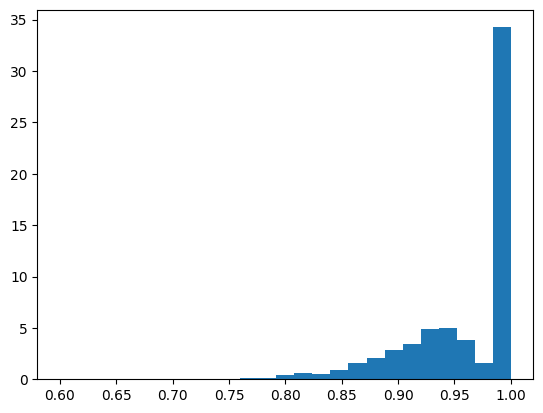

In [9]:
def get_id_distribution_per_ex(train_ids, tokenizer):
    occurences = []
    for s in other_examples:
        s1, s2 = s.texts
        out1 = tokenizer(s1)["input_ids"]
        out2 = tokenizer(s2)["input_ids"]
        
        ids_ = set(out1) | set(out2)
        overlap = len(ids_ & train_ids) / len(ids_)
        
        assert overlap <= 1
        assert overlap >= 0
        
        occurences.append(overlap)

    return occurences

bert_occurences = get_id_distribution_per_ex(train_ids_bert, bert_tokenizer)
plt.hist(bert_occurences, density=True, bins=25)
plt.show()

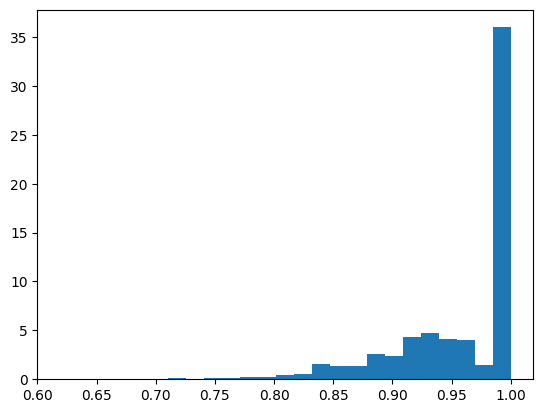

In [10]:
electra_occurences = get_id_distribution_per_ex(train_ids_electra, electra_tokenizer)
plt.hist(electra_occurences, density=True, bins=25)
plt.show()

## Scatter plot unsupervised output VS label

In [11]:
bert_preds = []
for x in tqdm(other_examples):
    out = bert_model.encode(x.texts)
    pred = cos_sim(out[0], out[1])
    bert_preds.append(pred[0, 0])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2879/2879 [00:18<00:00, 158.15it/s]


In [12]:
electra_preds = []
for x in tqdm(other_examples):
    out = electra_model.encode(x.texts)
    pred = cos_sim(out[0], out[1])
    electra_preds.append(pred[0, 0])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2879/2879 [00:18<00:00, 159.29it/s]


In [13]:
min(bert_occurences), max(bert_occurences), min(electra_occurences), max(electra_occurences)

(0.6, 1.0, 0.6190476190476191, 1.0)

In [14]:
scores = [x.label for x in other_examples]
scores[0:5]

[1.0, 0.95, 1.0, 0.48, 0.55]

In [15]:
min(bert_preds), max(bert_preds), min(electra_preds), max(bert_preds)

(tensor(0.6508), tensor(0.9936), tensor(0.5489), tensor(0.9936))

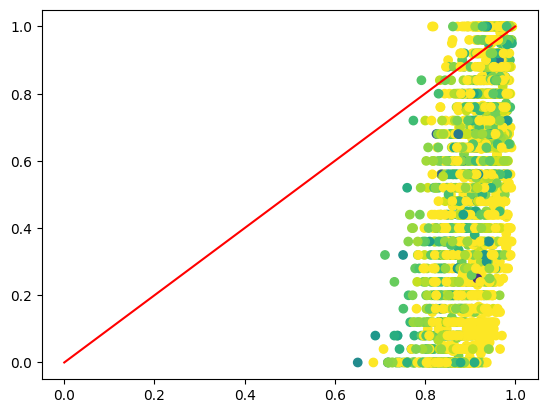

In [16]:
plt.scatter(bert_preds, scores, c=bert_occurences)
plt.plot([0.0, 1.0], [0.0, 1.0], c="r")
plt.show()

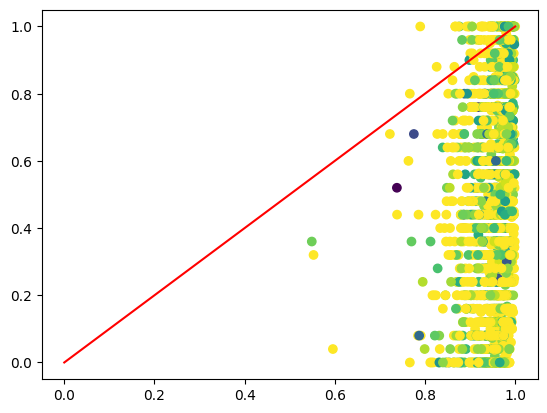

In [17]:
plt.scatter(electra_preds, scores, c=electra_occurences)
plt.plot([0.0, 1.0], [0.0, 1.0], c="r")
plt.show()

## Scatter plot supervised output mean pool VS label

In [18]:
#bert_model_tuned = SentenceTransformer("../output/training_stsbenchmark_bert-base-cased-2023-09-26_17-12-56")

#bert_preds = []
#for x in tqdm(other_examples):
#    out = bert_model_tuned.encode(x.texts)
#    pred = cos_sim(out[0], out[1])
#    bert_preds.append(pred[0, 0])

#plt.scatter(bert_preds, scores, c=bert_occurences, alpha=0.5)
#plt.plot([0.0, 1.0], [0.0, 1.0], c="r")
#plt.show()

In [19]:
#electra_model_tuned = SentenceTransformer("../output/training_stsbenchmark_google-electra-base-discriminator-2023-09-26_17-21-37")

#electra_preds = []
#for x in tqdm(other_examples):
#    out = electra_model_tuned.encode(x.texts)
#    pred = cos_sim(out[0], out[1])
#    electra_preds.append(pred[0, 0])
    
#plt.scatter(electra_preds, scores, c=electra_occurences, alpha=0.5)
#plt.plot([0.0, 1.0], [0.0, 1.0], c="r")
#plt.show()

## Scatter plot supervised output CLS VS label

In [20]:
#bert_model_tuned = SentenceTransformer("../output/training_stsbenchmark_bert-base-cased-2023-09-26_18-01-21")

#bert_preds = []
#for x in tqdm(other_examples):
#    out = bert_model_tuned.encode(x.texts)
#    pred = cos_sim(out[0], out[1])
#    bert_preds.append(pred[0, 0])
    
#plt.scatter(bert_preds, scores, c=bert_occurences, alpha=0.5)
#plt.plot([0.0, 1.0], [0.0, 1.0], c="r")
#plt.show()

In [21]:
#electra_model_tuned = SentenceTransformer("../output/training_stsbenchmark_google-electra-base-discriminator-2023-09-26_18-17-29")

#electra_preds = []
#for x in tqdm(other_examples):
#    out = electra_model_tuned.encode(x.texts)
#    pred = cos_sim(out[0], out[1])
#    electra_preds.append(pred[0, 0])
    
#plt.scatter(electra_preds, scores, c=electra_occurences, alpha=0.5)
#plt.plot([0.0, 1.0], [0.0, 1.0], c="r")
#plt.show()

# Word embedding norms

In [22]:
import torch
bert_model[0].auto_model.embeddings

BertEmbeddings(
  (word_embeddings): Embedding(28996, 768, padding_idx=0)
  (position_embeddings): Embedding(512, 768)
  (token_type_embeddings): Embedding(2, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

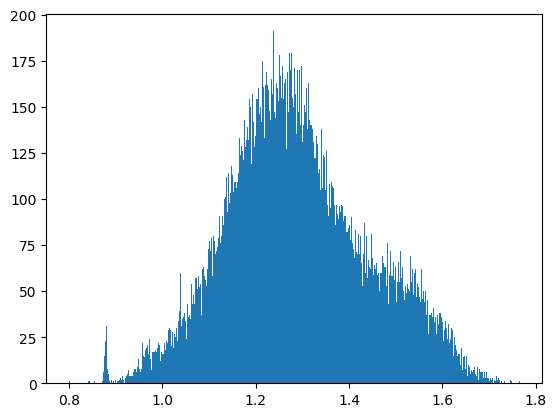

In [23]:
def calculate_norm_histogram(tokenizer, model, device="cuda:0"):
    norms = []
    for i in range(0, tokenizer.vocab_size):
        norms.append(model[0].auto_model.embeddings.word_embeddings(torch.tensor(i)
            .to(device)).norm().detach().cpu()
        )
    plt.hist(norms, bins=500)
    plt.show()
    return norms
    
bert_norms = calculate_norm_histogram(bert_tokenizer, bert_model)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


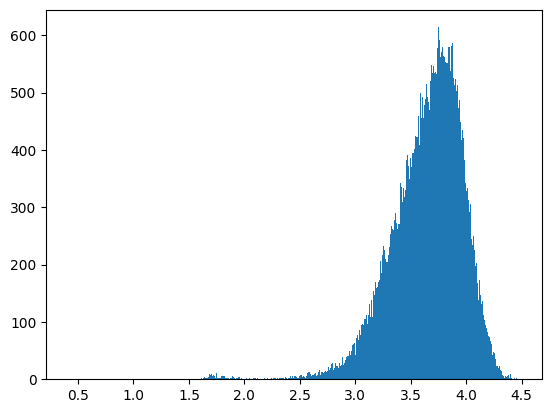

In [24]:
word_embedding_model = models.Transformer("roberta-base")
pooling_model = models.Pooling(
    word_embedding_model.get_word_embedding_dimension(),
    pooling_mode_mean_tokens=True,
    pooling_mode_cls_token=False,
    pooling_mode_max_tokens=False
)

roberta_model = SentenceTransformer(modules=[word_embedding_model, pooling_model]).to("cuda:0")
roberta_tokenizer = AutoTokenizer.from_pretrained("roberta-base")

roberta_norms = calculate_norm_histogram(roberta_tokenizer, roberta_model)

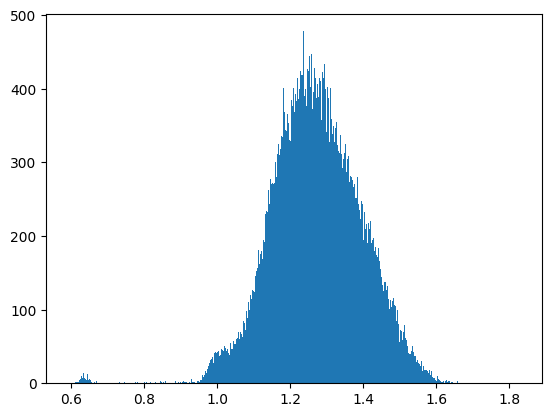

In [25]:
word_embedding_model = models.Transformer("microsoft/deberta-base")
pooling_model = models.Pooling(
    word_embedding_model.get_word_embedding_dimension(),
    pooling_mode_mean_tokens=True,
    pooling_mode_cls_token=False,
    pooling_mode_max_tokens=False
)

deberta_model = SentenceTransformer(modules=[word_embedding_model, pooling_model]).to("cuda:0")
deberta_tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-base")

deberta_norms = calculate_norm_histogram(deberta_tokenizer, deberta_model)

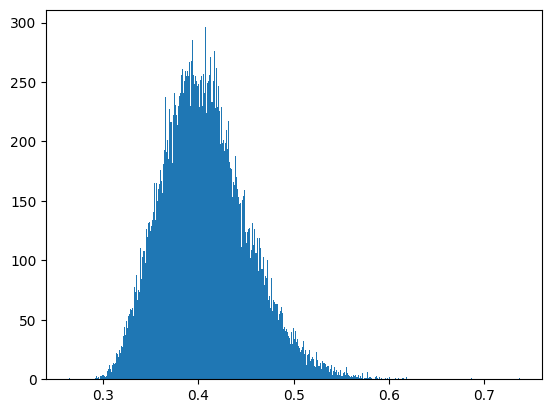

In [26]:
word_embedding_model = models.Transformer("albert-base-v2")
pooling_model = models.Pooling(
    word_embedding_model.get_word_embedding_dimension(),
    pooling_mode_mean_tokens=True,
    pooling_mode_cls_token=False,
    pooling_mode_max_tokens=False
)

albert_v2_model = SentenceTransformer(modules=[word_embedding_model, pooling_model]).to("cuda:0")
albert_v2_tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")

albert_v2_norms = calculate_norm_histogram(albert_v2_tokenizer, albert_v2_model)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/irep/.local/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


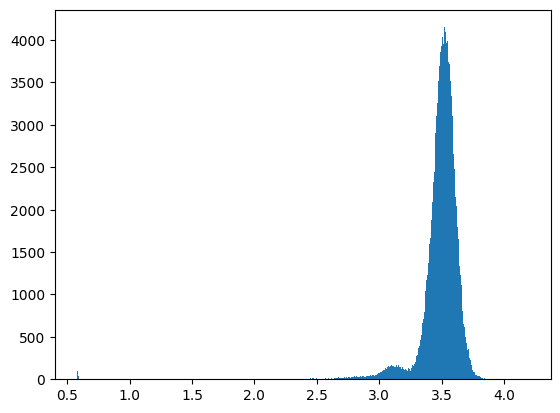

In [27]:
word_embedding_model = models.Transformer("microsoft/deberta-v3-base")
pooling_model = models.Pooling(
    word_embedding_model.get_word_embedding_dimension(),
    pooling_mode_mean_tokens=True,
    pooling_mode_cls_token=False,
    pooling_mode_max_tokens=False
)

deberta_v3_model = SentenceTransformer(modules=[word_embedding_model, pooling_model]).to("cuda:0")
deberta_v3_tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")

deberta_v3_norms = calculate_norm_histogram(deberta_v3_tokenizer, deberta_v3_model)

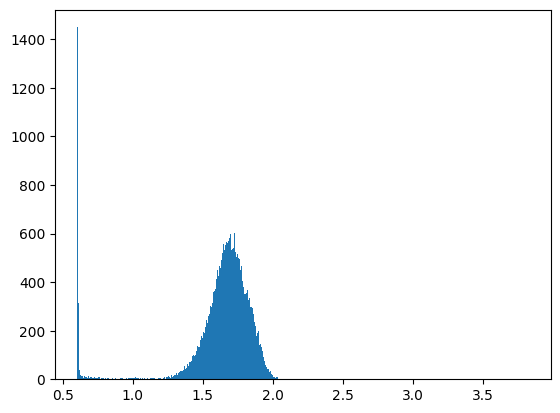

In [28]:
electra_norms = calculate_norm_histogram(electra_tokenizer, electra_model)

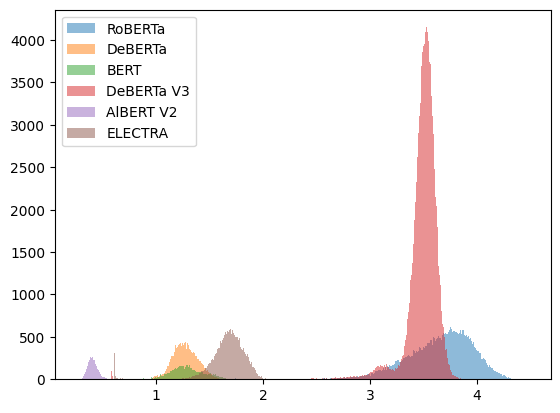

In [31]:
num_bins = 500
plt.hist(roberta_norms, bins=num_bins, label="RoBERTa", alpha=0.5)
plt.hist(deberta_norms, bins=num_bins, label="DeBERTa", alpha=0.5)
plt.hist(bert_norms, bins=num_bins, label="BERT", alpha=0.5)
plt.hist(deberta_v3_norms, bins=num_bins, label="DeBERTa V3", alpha=0.5)
plt.hist(albert_v2_norms, bins=num_bins, label="AlBERT V2", alpha=0.5)
plt.hist(electra_norms, bins=num_bins, label="ELECTRA", alpha=0.5)
plt.legend()
plt.show()

# Contextualized embedding norms

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5749/5749 [00:56<00:00, 101.62it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5749/5749 [01:04<00:00, 89.69it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been 

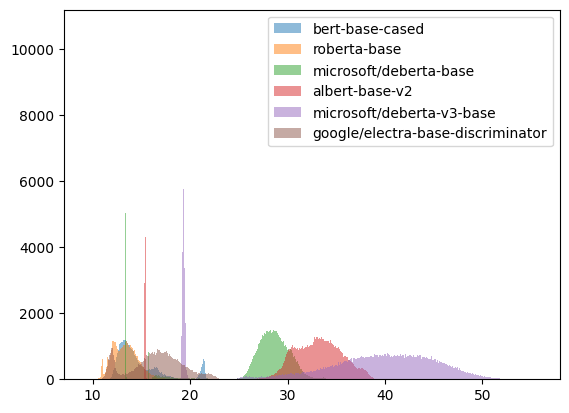

In [44]:
from transformers import AutoModel
from tqdm import tqdm

models = [
    "bert-base-cased", "roberta-base", "microsoft/deberta-base", "albert-base-v2", "microsoft/deberta-v3-base", "google/electra-base-discriminator"
]
device = "cuda:0"

def batch_to_device(x):
    return {k: v.to(device) for k, v in x.items()}

all_norms = []
for m in models:
    auto_model = AutoModel.from_pretrained(m).to(device)
    tokenizer = AutoTokenizer.from_pretrained(m)

    norms = []
    with torch.no_grad():
        for t in tqdm(train_examples):
            tokenized1 = batch_to_device(
                tokenizer(t.texts[0], padding="do_not_pad", return_tensors="pt")
            )
            out1 = auto_model(**tokenized1).last_hidden_state[0]
            norms.extend(out1.norm(dim=-1).cpu().tolist())
            
            tokenized2 = batch_to_device(
                tokenizer(t.texts[1], padding="do_not_pad", return_tensors="pt")
            )
            out2 = auto_model(**tokenized2).last_hidden_state[0]
            norms.extend(out2.norm(dim=-1).cpu().tolist())
    all_norms.append(norms)
    plt.hist(norms, bins=500, label=m, alpha=0.5)
plt.legend()
plt.show()

In [45]:
for m, x in zip(models, all_norms):
    print(m, np.std(np.array(x), ddof=1))

bert-base-cased 2.4092845833962286
roberta-base 1.3058863938281848
microsoft/deberta-base 5.335502562995856
albert-base-v2 5.032710040731085
microsoft/deberta-v3-base 8.674784375221453
google/electra-base-discriminator 2.747726004396605
